<a href="https://colab.research.google.com/github/Pashtetickus/ramachandranJET/blob/master/Ramachandran.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

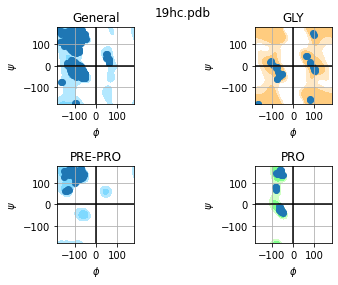

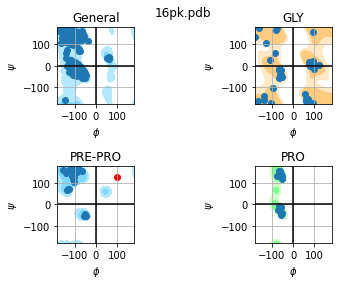

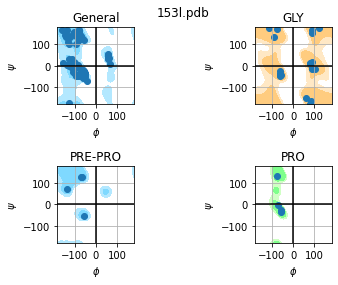

In [11]:
# for the first time uncomment !pip...
# !pip install biopython

from __future__ import division, print_function
import matplotlib.colors as mplcolors
from matplotlib import colors
import matplotlib.pyplot as plt
import os
import math
import sys
import numpy as np
from Bio import PDB

# to clear the output
import warnings
warnings.filterwarnings(action='ignore')



RAMA_PREFERENCES = {
    "General": {
        "file": os.path.join('/Rama/data', 'pref_general.data'),
        "cmap": mplcolors.ListedColormap(['#FFFFFF', '#B3E8FF', '#7FD9FF']),
        "bounds": [0, 0.0005, 0.02, 1],
    },
    "GLY": {
        "file": os.path.join('/Rama/data', 'pref_glycine.data'),
        "cmap": mplcolors.ListedColormap(['#FFFFFF', '#FFE8C5', '#FFCC7F']),
        "bounds": [0, 0.002, 0.02, 1],
    },
    "PRO": {
        "file": os.path.join('/Rama/data', 'pref_proline.data'),
        "cmap": mplcolors.ListedColormap(['#FFFFFF', '#D0FFC5', '#7FFF8C']),
        "bounds": [0, 0.002, 0.02, 1],
    },
    "PRE-PRO": {
        "file": os.path.join('/Rama/data', 'pref_preproline.data'),
        "cmap": mplcolors.ListedColormap(['#FFFFFF', '#B3E8FF', '#7FD9FF']),
        "bounds": [0, 0.002, 0.02, 1],
    }
}

RAMA_PREF_VALUES = None


def _cache_RAMA_PREF_VALUES():
    RAMA_PREF_VALUES = {}
    for key, val in RAMA_PREFERENCES.items():
        RAMA_PREF_VALUES[key] = np.full((360, 360), 0, dtype=np.float64)
        with open(os.path.join('', val["file"])) as fn:
            for line in fn:
                if line.startswith("#"):
                    continue
                else:
                    x = int(float(line.split()[1]))
                    y = int(float(line.split()[0]))
                    RAMA_PREF_VALUES[key][x + 180][y + 180] \
                        = RAMA_PREF_VALUES[key][x + 179][y + 179] \
                        = RAMA_PREF_VALUES[key][x + 179][y + 180] \
                        = RAMA_PREF_VALUES[key][x + 180][y + 179] \
                        = float(line.split()[2]) 
    return RAMA_PREF_VALUES


def calc_ramachandran(file_name_list):
    """
    Main calculation and plotting definition
    :param file_name_list: List of PDB files to plot
    :return: Nothing
    """
    global RAMA_PREF_VALUES

    if RAMA_PREF_VALUES is None:
        RAMA_PREF_VALUES = _cache_RAMA_PREF_VALUES()

    # Read in the expected torsion angles
    normals = {}
    outliers = {}
    for key, val in RAMA_PREFERENCES.items():
        normals[key] = {"x": [], "y": []}
        outliers[key] = {"x": [], "y": []}

    # Calculate the torsion angle of the inputs
    for inp in file_name_list:
        structure = PDB.PDBParser().get_structure('input_structure', inp)
        for model in structure:
            for chain in model:
                polypeptides = PDB.PPBuilder().build_peptides(chain)
                for poly_index, poly in enumerate(polypeptides):
                    phi_psi = poly.get_phi_psi_list()
                    for res_index, residue in enumerate(poly):
                        res_name = "{}".format(residue.resname)
                        res_num = residue.id[1]
                        phi, psi = phi_psi[res_index]
                        if phi and psi:
                            if str(poly[res_index + 1].resname) == "PRO":
                                aa_type = "PRE-PRO"
                            elif res_name == "PRO":
                                aa_type = "PRO"
                            elif res_name == "GLY":
                                aa_type = "GLY"
                            else:
                                aa_type = "General"
                            if RAMA_PREF_VALUES[aa_type][int(math.degrees(psi)) + 180][int(math.degrees(phi)) + 180] < \
                                    RAMA_PREFERENCES[aa_type]["bounds"][1]:
                                outliers[aa_type]["x"].append(math.degrees(phi))
                                outliers[aa_type]["y"].append(math.degrees(psi))
                            else:
                                normals[aa_type]["x"].append(math.degrees(phi))
                                normals[aa_type]["y"].append(math.degrees(psi))
    return normals, outliers

    
def plot_ramachandran(normals, outliers, pdb_name):
    global RAMA_PREF_VALUES
    if RAMA_PREF_VALUES is None:
        RAMA_PREF_VALUES = _cache_RAMA_PREF_VALUES()
        

    for idx, (key, val) in enumerate(sorted(RAMA_PREFERENCES.items(), key=lambda x: x[0].lower())):
        plt.subplot(2, 2, idx + 1)
        plt.title(key)
        plt.imshow(RAMA_PREF_VALUES[key], cmap=RAMA_PREFERENCES[key]["cmap"],
                   norm=colors.BoundaryNorm(RAMA_PREFERENCES[key]["bounds"], RAMA_PREFERENCES[key]["cmap"].N),
                   extent=(-180, 180, 180, -180))
        plt.scatter(normals[key]["x"], normals[key]["y"])
        plt.scatter(outliers[key]["x"], outliers[key]["y"], color="red")
        plt.xlim([-180, 180])
        plt.ylim([-180, 180])
        plt.plot([-180, 180], [0, 0], color="black")
        plt.plot([0, 0], [-180, 180], color="black")
        plt.locator_params(axis='x', nbins=7)
        plt.xlabel(r'$\phi$')
        plt.ylabel(r'$\psi$')
        plt.grid()

    plt.suptitle(pdb_name)
    plt.tight_layout()
    plt.show()

pdbfiles = []
mypdblist = []
for i in os.walk('/Rama/my_pdbs'):
    pdbfiles.append(i)
for address, dirs, files in pdbfiles:
    for file in files:
        mypdblist.append(address + '/' + file)

AMOUNT_OF_PDBfiles = 3

for pdb_id in range(AMOUNT_OF_PDBfiles):
    normals, outliers = calc_ramachandran([mypdblist[pdb_id]])
    _, pdb_name = os.path.split(mypdblist[pdb_id])
    plot_ramachandran(normals, outliers, pdb_name)